# RFM Clustering & Customer Intelligence
## Objective

This notebook builds on the EDA phase and focuses on customer segmentation using RFM metrics and unsupervised learning. The objective is to identify economically meaningful customer groups that support strategic decisions in marketing, operations, and inventory management.

Scope of this notebook:

- RFM feature engineering

- Scaling and clustering (K-Means)

- Cluster validation

-  Business-oriented segment interpretation

# 1. Environment Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Project Paths & Data Loading

In [4]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


DATA_PATH = os.path.join(
    PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)


df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

if "TotalSum" not in df.columns:
    df["TotalSum"] = df["Quantity"] * df["Price"]


df["Year"] = df["InvoiceDate"].dt.year

# 3. RFM Feature Engineering

RFM metrics capture three key dimensions of customer value:

- Recency: How recently a customer purchased

- Frequency: How often they purchase

- Monetary: How much revenue they generate

In [6]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


rfm = (
    df.groupby("Customer ID")
    .agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "TotalSum": "sum"
    })
    .rename(columns={
    "InvoiceDate": "Recency",
    "Invoice": "Frequency",
    "TotalSum": "Monetary"
    })
    )


rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,529,11,372.86
12347.0,2,8,5377.72
12348.0,75,5,1057.24
12349.0,19,3,3498.94
12350.0,310,1,294.40


# 4. Scaling & Distribution Check
RFM variables are highly skewed and require normalization before clustering.

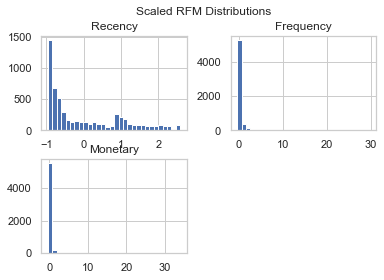

In [13]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm),
    index=rfm.index,
    columns=rfm.columns
)

rfm_scaled.hist(bins=30)
plt.suptitle("Scaled RFM Distributions")
plt.show()

# 5. K-Means Clustering

In [15]:
# Model training 

kmeans = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    random_state=42
)


rfm["Cluster_ID"] = kmeans.fit_predict(rfm_scaled)

# Cluster Validation

silhouette = silhouette_score(rfm_scaled, rfm["Cluster_ID"])
print(f"Silhouette Score:{silhouette:.3f}")

Silhouette Score:0.594


Interpretation:

- Values > 0.3 indicate acceptable separation for behavioral data

# 6. RFM-Based Business Scoring
To translate clusters into business-readable segments, we compute quintile-based RFM scores

In [16]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

# 7. Segment Definition (Business Logic)

In [19]:
def assign_segment(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions (VIP)"
    elif m >= 4 and r >= 3:
        return "Big Spenders"
    elif r <= 2:
        return "At Risk / Hibernating"
    else:
        return "Core Customers"


rfm["Segment"] = rfm.apply(assign_segment, axis=1)

rfm["Segment"].value_counts(normalize=True) * 100

Segment
At Risk / Hibernating    39.917199
Core Customers           26.806969
Champions (VIP)          22.183888
Big Spenders             11.091944
Name: proportion, dtype: float64

# 8. Cluster & Segment Consistency

In [20]:
pd.crosstab(rfm["Segment"], rfm["Cluster_ID"], normalize="index") * 100

Cluster_ID,0,1,2,3
Segment,,,,
At Risk / Hibernating,16.162489,0.043215,83.535004,0.259291
Big Spenders,97.511664,0.000000,0.000000,2.488336
Champions (VIP),80.171073,0.855365,0.000000,18.973561
Core Customers,100.000000,0.000000,0.000000,0.000000


This matrix validates the alignment between statistical clusters and business rules.

# 9. Strategic Interpretation

- Champions (VIP): High value, low churn risk → retention priority

- Big Spenders: High monetary, moderate frequency → upsell potential

- Core Customers: Stable revenue base → operational backbone

- At Risk: Declining engagement → reactivation candidates

# 10. Next Step

➡ Proceed to Inventory & ABC Impact Analysis to connect customer behavior with stock and revenue concentration.

This modular design keeps modeling interpretable, auditable, and decision-oriented.